# Proyecto Final PDS

# Objetivo
- Crear un transmisor y receptor por audio de manera que logre recibir y transmitir una señal usando 8qpsk


# Creacion de señal de informacion

In [2]:
# Codificar mensaje en ascii y devolverlo en binario
def ascii_a_binario(mensaje):
    binario = ''.join(format(ord(char), '08b') for char in mensaje)
    return binario
# Decodificar mensaje en binario y devolverlo en ascii
def binario_a_ascii(binario):
    mensaje = ''.join(chr(int(binario[i:i+8], 2)) for i in range(0, len(binario), 8))
    return mensaje
# Ejemplo de uso

mensaje = "Hola, Mundo!"
binario = ascii_a_binario(mensaje)
print(f"Mensaje original: {mensaje}")
print(f"Mensaje en binario: {binario}")
mensaje_decodificado = binario_a_ascii(binario)
print(f"Mensaje decodificado: {mensaje_decodificado}")

Mensaje original: Hola, Mundo!
Mensaje en binario: 010010000110111101101100011000010010110000100000010011010111010101101110011001000110111100100001
Mensaje decodificado: Hola, Mundo!


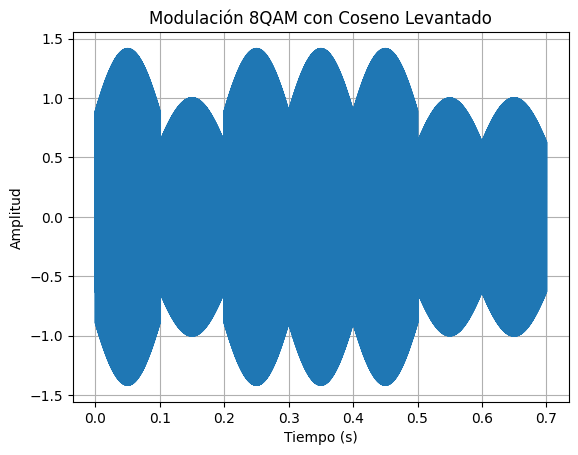

In [3]:
import numpy as np
import math

# --- Pulso Raised Cosine básico ---
def raised_cosine_pulse(Tb, fs, beta=0.25):
    N = int(Tb * fs)
    t = np.linspace(-Tb/2, Tb/2, N)

    h = np.zeros(N)
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1.0
        elif abs(1 - (2 * beta * ti/Tb)**2) < 1e-8:
            h[i] = (np.pi/4) * np.sinc(1/(2*beta))
        else:
            h[i] = (np.sin(np.pi * ti / Tb) / (np.pi * ti / Tb)) * \
                   (np.cos(np.pi * beta * ti / Tb) /
                    (1 - (2 * beta * ti / Tb)**2))

    return h, N


# --- Función 8QAM ---
def modulate_8qam(bits, Tb, fs, fc, beta=0.25):
    """
    Modula una cadena de bits usando 8QAM + Raised Cosine.

    bits : str       Cadena de bits (long múltiplo de 3)
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    # Verificación
    if len(bits) % 3 != 0:
        raise ValueError("La cantidad de bits debe ser múltiplo de 3 para 8QAM.")

    # --- Mapeo Gray 3 bits → (I,Q) ---
    mapping = {
        "000": (-1, -1),
        "001": (-1,  0),
        "011": (-1, +1),
        "010": ( 0, +1),
        "110": (+1, +1),
        "111": (+1,  0),
        "101": (+1, -1),
        "100": ( 0, -1),
    }

    symbols = [bits[i:i+3] for i in range(0, len(bits), 3)]
    IQ = np.array([mapping[s] for s in symbols])

    # --- Pulso Raised Cosine ---
    h, N = raised_cosine_pulse(Tb, fs, beta)

    total_samples = len(symbols) * N
    t = np.linspace(0, Tb * len(symbols), total_samples, endpoint=False)

    # Señales banda base I(t) y Q(t)
    I = np.zeros(total_samples)
    Q = np.zeros(total_samples)

    for k, (I0, Q0) in enumerate(IQ):
        start = k * N
        end = start + N
        I[start:end] += I0 * h
        Q[start:end] += Q0 * h

    # --- Modulación en frecuencia ---
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)

    # Señal 8QAM pasabanda
    s = I * carrier_cos - Q * carrier_sin

    return t, s, I, Q

import matplotlib.pyplot as plt

bits = "000001011110101100111"   # múltiplo de 3
Tb = 0.1        # duración de símbolo
fs = 100000
fc = 2000
beta = 0.25

t, s, I, Q = modulate_8qam(bits, Tb, fs, fc, beta)

plt.plot(t, s)
plt.title("Modulación 8QAM con Coseno Levantado")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.grid()
plt.show()


In [24]:
import numpy as np
from scipy.io.wavfile import write

def save_as_wav(filename, signal, fs):
    """
    Guarda una señal en un archivo WAV.

    filename : str      -> Nombre del archivo, ej: "senal_8qam.wav"
    signal   : ndarray  -> Señal normalizada (float32 recomendado)
    fs       : int      -> Frecuencia de muestreo
    """
    # Asegurar normalización correcta
    signal_norm = signal / np.max(np.abs(signal))

    # Convertir a float32 para formato WAV estándar
    audio = (signal_norm).astype(np.float32)

    write(filename, fs, audio)
    print(f"✔ Archivo WAV guardado como: {filename}")

def prepare_audio_signal(signal, fs):
    """
    Prepara una señal para reproducirla con: display(Audio(a, rate=fs)).
    Normaliza amplitud y la deja en tipo float.
    
    signal : ndarray  -> señal modulada
    fs     : int      -> frecuencia de muestreo
    """
    # Normalizar amplitud para evitar clipping
    signal_norm = signal / np.max(np.abs(signal))

    # Convertir a float32 para compatibilidad
    audio = signal_norm.astype(np.float32)

    return audio, fs
from IPython.display import Audio, display

bits = "010111000101011110001100010011111000101001110100011010001111"  # múltiplo de 3
Tb = 0.3
fs = 48000
fc = 3000

# Modulación 8QAM
t, s, I, Q = modulate_8qam(bits, Tb, fs, fc)

# Preparar señal para escucha
a, fs_a = prepare_audio_signal(s, fs)

# Reproducir
display(Audio(a, rate=fs_a))

# Guardar
save_as_wav("senal_8qam.wav", a, fs_a)


✔ Archivo WAV guardado como: senal_8qam.wav
